In [8]:
# first thing is to load the data from the synthetic action combinations

import pandas as pd
import json
from pathlib import Path
import os
print(os.getcwd())


if(not Path("synthetic_action_pair_scores.json").exists()):
    !wget https://github.com/isaaccodekill/Human-action-prioritizer/raw/main/Services/prioritizer/src/prioritizer/data/synthetic_action_pair_scores.json

data_path = Path("synthetic_action_pair_scores.json")


data = []
with open(data_path, "r") as f:
    data = json.load(f)

df = pd.json_normalize(data)

print(df.head())




/content
   score action_a.action                        action_a.solution  \
0      1         Improve                                    Diets   
1      0         Protect            Grasslands & Savannas: Boreal   
2      0         Protect  Coastal Wetlands: Salt marsh ecosystems   
3      1         Improve              Nonmotorized Transportation   
4      1          Deploy                             LED Lighting   

  action_a.solution_classification                    action_a.mode  \
0               Highly Recommended                    Cut Emissions   
1               Highly Recommended  Cut Emissions and Remove Carbon   
2               Highly Recommended                    Cut Emissions   
3               Highly Recommended                    Cut Emissions   
4               Highly Recommended                    Cut Emissions   

                          action_a.sector             action_a.cluster  \
0  Food, Agriculture, Land & Ocean (FALO)         Curb Growing Demands   
1

In [9]:
# Feature Engineering: Action difference features & User-action relevance features
import numpy as np

# --- Helper functions ---

def parse_ghg_impact(val):
    """Parse ghg_impact string like '1.40 to 2.80' into a midpoint number."""
    if val is None or pd.isna(val):
        return 0.0
    val = str(val).strip()
    if "to" in val:
        parts = val.split("to")
        try:
            lo = float(parts[0].strip())
            hi = float(parts[1].strip())
            return (lo + hi) / 2
        except ValueError:
            return 0.0
    try:
        return float(val)
    except ValueError:
        return 0.0

SPEED_MAP = {"Emergency Brake": 3, "Gradual": 2, "Delayed": 1}

def encode_speed(val):
    if val is None or pd.isna(val):
        return 0
    return SPEED_MAP.get(str(val).strip(), 0)

def count_benefits(val):
    """Count comma-separated benefit items. None/NaN = 0."""
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return 0
    items = [x.strip() for x in str(val).split(",") if x.strip()]
    return len(items)

MODE_MAP = {"Cut Emissions": 1, "Remove Carbon": 2, "Cut Emissions and Remove Carbon": 3}

def encode_mode(val):
    if val is None or pd.isna(val):
        return 0
    return MODE_MAP.get(str(val).strip(), 0)

def sector_match(sector, transport, diet, energy_source):
    """Check if action sector relates to user's primary emission source."""
    if sector is None or pd.isna(sector):
        return 0
    sector = str(sector).lower()
    if "transport" in sector and transport in ("car", "motorcycle"):
        return 1
    if ("electricity" in sector or "building" in sector) and energy_source == "grid":
        return 1
    if "food" in sector and diet in ("heavy_meat", "moderate_meat"):
        return 1
    return 0

def cost_feasibility(cost, income_level):
    """Is the action cost reasonable for the user's income?"""
    if cost is None or pd.isna(cost):
        return 0.5  # unknown cost, neutral
    if cost < 0:
        return 1  # net savings, always feasible
    if income_level == "high":
        return 1
    if income_level == "medium":
        return 0.5 if cost > 1000 else 1
    # low income
    return 0 if cost > 500 else 0.5

# --- Action difference features ---

df["ghg_impact_a"] = df["action_a.ghg_impact"].apply(parse_ghg_impact)
df["ghg_impact_b"] = df["action_b.ghg_impact"].apply(parse_ghg_impact)
df["ghg_impact_diff"] = df["ghg_impact_a"] - df["ghg_impact_b"]

df["cost_diff"] = df["action_a.cost"].fillna(0) - df["action_b.cost"].fillna(0)

df["speed_a"] = df["action_a.speed_of_action"].apply(encode_speed)
df["speed_b"] = df["action_b.speed_of_action"].apply(encode_speed)
df["speed_diff"] = df["speed_a"] - df["speed_b"]

df["env_benefits_a"] = df["action_a.environment_benefits"].apply(count_benefits)
df["env_benefits_b"] = df["action_b.environment_benefits"].apply(count_benefits)
df["env_benefits_diff"] = df["env_benefits_a"] - df["env_benefits_b"]

df["wellbeing_a"] = df["action_a.human_wellbeing_benefits"].apply(count_benefits)
df["wellbeing_b"] = df["action_b.human_wellbeing_benefits"].apply(count_benefits)
df["wellbeing_diff"] = df["wellbeing_a"] - df["wellbeing_b"]

df["adaptation_a"] = df["action_a.climate_adaptation_benefits"].apply(count_benefits)
df["adaptation_b"] = df["action_b.climate_adaptation_benefits"].apply(count_benefits)
df["adaptation_diff"] = df["adaptation_a"] - df["adaptation_b"]

df["mode_a"] = df["action_a.mode"].apply(encode_mode)
df["mode_b"] = df["action_b.mode"].apply(encode_mode)
df["mode_diff"] = df["mode_a"] - df["mode_b"]

# --- User-action relevance features ---

df["sector_match_a"] = df.apply(
    lambda r: sector_match(r["action_a.sector"], r["user_profile.primary_transport"], r["user_profile.diet"], r["user_profile.energy_source"]), axis=1
)
df["sector_match_b"] = df.apply(
    lambda r: sector_match(r["action_b.sector"], r["user_profile.primary_transport"], r["user_profile.diet"], r["user_profile.energy_source"]), axis=1
)
df["sector_match_diff"] = df["sector_match_a"] - df["sector_match_b"]

df["cost_feasibility_a"] = df.apply(
    lambda r: cost_feasibility(r["action_a.cost"], r["user_profile.income_level"]), axis=1
)
df["cost_feasibility_b"] = df.apply(
    lambda r: cost_feasibility(r["action_b.cost"], r["user_profile.income_level"]), axis=1
)
df["cost_feasibility_diff"] = df["cost_feasibility_a"] - df["cost_feasibility_b"]

# --- Summary ---
feature_cols = [
    "ghg_impact_diff", "cost_diff", "speed_diff",
    "env_benefits_diff", "wellbeing_diff", "adaptation_diff", "mode_diff",
    "sector_match_a", "sector_match_b", "sector_match_diff",
    "cost_feasibility_a", "cost_feasibility_b", "cost_feasibility_diff",
]

print(f"Features engineered: {len(feature_cols)} columns")
print(f"Dataset shape: {df.shape}")
df[feature_cols + ["score"]].head(10)


Features engineered: 13 columns
Dataset shape: (7500, 67)


,ghg_impact_diff,cost_diff,speed_diff,env_benefits_diff,wellbeing_diff,adaptation_diff,mode_diff,sector_match_a,sector_match_b,sector_match_diff,cost_feasibility_a,cost_feasibility_b,cost_feasibility_diff,score
0,1.775,-6.96,0,2,0,-2,-2,1,0,1,1.0,1.0,0.0,1
1,-1.775,6.96,0,-2,0,2,2,0,1,-1,1.0,1.0,0.0,0
2,-1.635,1773.00,1,1,1,1,0,0,1,-1,0.5,1.0,-0.5,0
3,1.635,-1773.00,-1,-1,-1,-1,0,1,0,1,1.0,0.5,0.5,1
4,-1.835,-175.00,0,0,0,0,0,0,0,0,1.0,0.5,0.5,1
5,1.835,175.00,0,0,0,0,0,0,0,0,0.5,1.0,-0.5,0
6,0.385,-51.00,2,0,0,-3,-2,0,0,0,0.5,0.5,0.0,1
7,-0.385,51.00,-2,0,0,3,2,0,0,0,0.5,0.5,0.0,0
8,0.200,-216.20,-1,2,0,2,-1,0,1,-1,0.5,0.5,0.0,1
9,-0.200,216.20,1,-2,0,-2,1,1,0,1,0.5,0.5,0.0,0


In [10]:
# User context features — same for both actions but helps the model learn interactions

INCOME_MAP = {"high": 3, "medium": 2, "low": 1}
HOUSING_MAP = {"house": 1, "apartment": 0}

# Income level
df["income_level"] = df["user_profile.income_level"].map(INCOME_MAP).fillna(0).astype(int)

# Housing type
df["housing_type"] = df["user_profile.housing_type"].map(HOUSING_MAP).fillna(0).astype(int)

# Climate zone — one-hot encode
climate_dummies = pd.get_dummies(df["user_profile.climate_zone"], prefix="climate")
df = pd.concat([df, climate_dummies], axis=1)

# Primary transport — one-hot encode
transport_dummies = pd.get_dummies(df["user_profile.primary_transport"], prefix="transport")
df = pd.concat([df, transport_dummies], axis=1)

# Diet — one-hot encode
diet_dummies = pd.get_dummies(df["user_profile.diet"], prefix="diet")
df = pd.concat([df, diet_dummies], axis=1)

# Update feature columns list with user context features
user_context_cols = (
    ["income_level", "housing_type"]
    + [c for c in df.columns if c.startswith("climate_")]
    + [c for c in df.columns if c.startswith("transport_")]
    + [c for c in df.columns if c.startswith("diet_")]
)

all_feature_cols = feature_cols + user_context_cols

print(f"User context features: {len(user_context_cols)}")
print(f"Total features: {len(all_feature_cols)}")
print(f"Dataset shape: {df.shape}")
print(f"\nUser context columns: {user_context_cols}")
df[all_feature_cols + ["score"]].head(10)


User context features: 13
Total features: 26
Dataset shape: (7500, 80)

User context columns: ['income_level', 'housing_type', 'climate_arid', 'climate_cold', 'climate_temperate', 'climate_tropical', 'transport_bicycle', 'transport_car', 'transport_motorcycle', 'transport_public_transit', 'diet_heavy_meat', 'diet_moderate_meat', 'diet_vegetarian']


,ghg_impact_diff,cost_diff,speed_diff,env_benefits_diff,wellbeing_diff,adaptation_diff,mode_diff,sector_match_a,sector_match_b,sector_match_diff,...,climate_temperate,climate_tropical,transport_bicycle,transport_car,transport_motorcycle,transport_public_transit,diet_heavy_meat,diet_moderate_meat,diet_vegetarian,score
0,1.775,-6.96,0,2,0,-2,-2,1,0,1,...,False,True,False,False,True,False,False,True,False,1
1,-1.775,6.96,0,-2,0,2,2,0,1,-1,...,False,True,False,False,True,False,False,True,False,0
2,-1.635,1773.00,1,1,1,1,0,0,1,-1,...,False,True,False,False,True,False,False,True,False,0
3,1.635,-1773.00,-1,-1,-1,-1,0,1,0,1,...,False,True,False,False,True,False,False,True,False,1
4,-1.835,-175.00,0,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,True,False,1
5,1.835,175.00,0,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,True,False,0
6,0.385,-51.00,2,0,0,-3,-2,0,0,0,...,False,True,False,False,True,False,False,True,False,1
7,-0.385,51.00,-2,0,0,3,2,0,0,0,...,False,True,False,False,True,False,False,True,False,0
8,0.200,-216.20,-1,2,0,2,-1,0,1,-1,...,False,True,False,False,True,False,False,True,False,1
9,-0.200,216.20,1,-2,0,-2,1,1,0,1,...,False,True,False,False,True,False,False,True,False,0


In [11]:
# Monotone constraints for XGBoost
# Maps each feature to a constraint: 1 = positive (higher favors A), -1 = negative (higher favors B), 0 = unconstrained
# Must match the order of all_feature_cols

monotone_constraints = (
    # Action difference features (13)
    1,   # ghg_impact_diff — higher diff = A has more impact = favor A
    -1,  # cost_diff — higher diff = A is more expensive = favor B
    1,   # speed_diff — higher diff = A is faster = favor A
    1,   # env_benefits_diff — more co-benefits = favor A
    1,   # wellbeing_diff — more co-benefits = favor A
    1,   # adaptation_diff — more adaptation = favor A
    0,   # mode_diff — no clear directional relationship
    0,   # sector_match_a — contextual, used via diff
    0,   # sector_match_b — contextual, used via diff
    1,   # sector_match_diff — better match to user = favor A
    0,   # cost_feasibility_a — contextual, used via diff
    0,   # cost_feasibility_b — contextual, used via diff
    1,   # cost_feasibility_diff — more feasible for user = favor A

    # User context features (13) — all unconstrained
    0,   # income_level
    0,   # housing_type
    0,   # climate_arid
    0,   # climate_cold
    0,   # climate_temperate
    0,   # climate_tropical
    0,   # transport_bicycle
    0,   # transport_car
    0,   # transport_motorcycle
    0,   # transport_public_transit
    0,   # diet_heavy_meat
    0,   # diet_moderate_meat
    0,   # diet_vegetarian
)

assert len(monotone_constraints) == len(all_feature_cols), \
    f"Mismatch: {len(monotone_constraints)} constraints vs {len(all_feature_cols)} features"

print(f"Monotone constraints defined for {len(monotone_constraints)} features")
print("\nConstrained features:")
for col, c in zip(all_feature_cols, monotone_constraints):
    if c != 0:
        direction = "positive (favor A)" if c == 1 else "negative (favor B)"
        print(f"  {col}: {direction}")


Monotone constraints defined for 26 features

Constrained features:
  ghg_impact_diff: positive (favor A)
  cost_diff: negative (favor B)
  speed_diff: positive (favor A)
  env_benefits_diff: positive (favor A)
  wellbeing_diff: positive (favor A)
  adaptation_diff: positive (favor A)
  sector_match_diff: positive (favor A)
  cost_feasibility_diff: positive (favor A)


In [15]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


model = xgb.XGBClassifier(
    objective="binary:logistic",
    monotone_constraints=monotone_constraints,
    random_state=42,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
)

Y = df["score"]
X = df[all_feature_cols]

scores = cross_val_score(model, X, Y, cv=5, scoring="roc_auc")

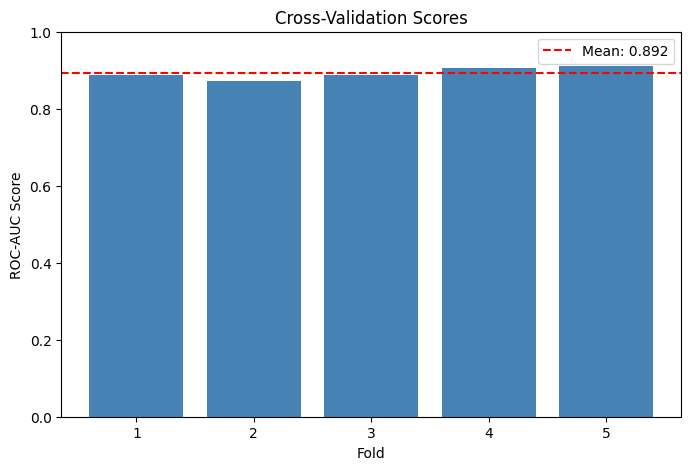

In [16]:
import matplotlib.pyplot as plt

# Simple bar chart of fold scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), scores, color="steelblue")
plt.axhline(y=scores.mean(), color="red", linestyle="--", label=f"Mean: {scores.mean():.3f}")
plt.xlabel("Fold")
plt.ylabel("ROC-AUC Score")
plt.title("Cross-Validation Scores")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [17]:
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    "n_estimators": [100, 150, 200, 300, 500],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.5, 1.0, 1.5, 2.0, 2.5],
    "reg_alpha": [0.0, 0.1, 0.3, 0.5, 1.0],
}

search = RandomizedSearchCV(
    xgb.XGBClassifier(
        objective="binary:logistic",
        monotone_constraints=monotone_constraints,
        random_state=42,
    ),
    param_distributions=param_distributions,
    n_iter=50,  # try 50 random combinations
    cv=5,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
)

search.fit(X, Y)

print(f"\nBest ROC-AUC: {search.best_score_:.4f}")
print(f"Best params: {search.best_params_}")

# Use the best model going forward
model = search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best ROC-AUC: 0.9095
Best params: {'subsample': 1.0, 'reg_lambda': 2.5, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.15, 'colsample_bytree': 1.0}


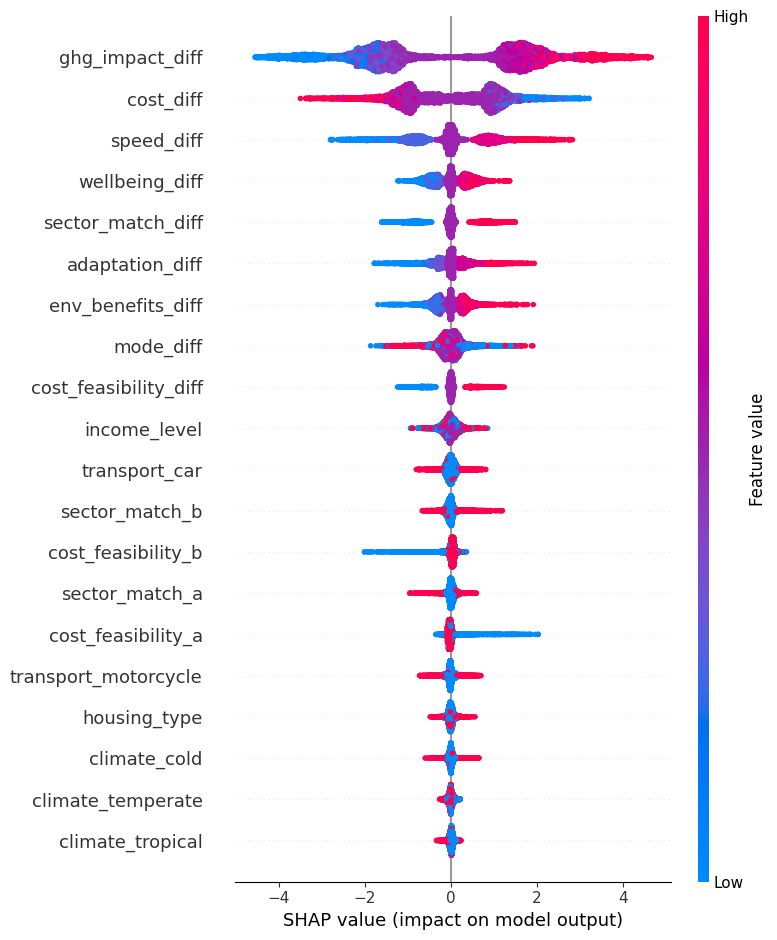

In [18]:
# shap to explain feature importance and effects
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# plot shap summary plot
shap.summary_plot(shap_values, X, feature_names=all_feature_cols)

In [20]:
import joblib
from google.colab import drive
drive.mount("/content/drive")

model_path = "/content/drive/My Drive/action_prioritization_model.joblib"
joblib.dump(model, model_path)

print(f"Model saved to {model_path}")


Mounted at /content/drive
Model saved to /content/drive/My Drive/action_prioritization_model.joblib
